# Deep dynamic modeling with just two timepoints - can we still get individual trajectories? 

## Exemplary application: A setting in epidemiological cohort studies and clinical registries

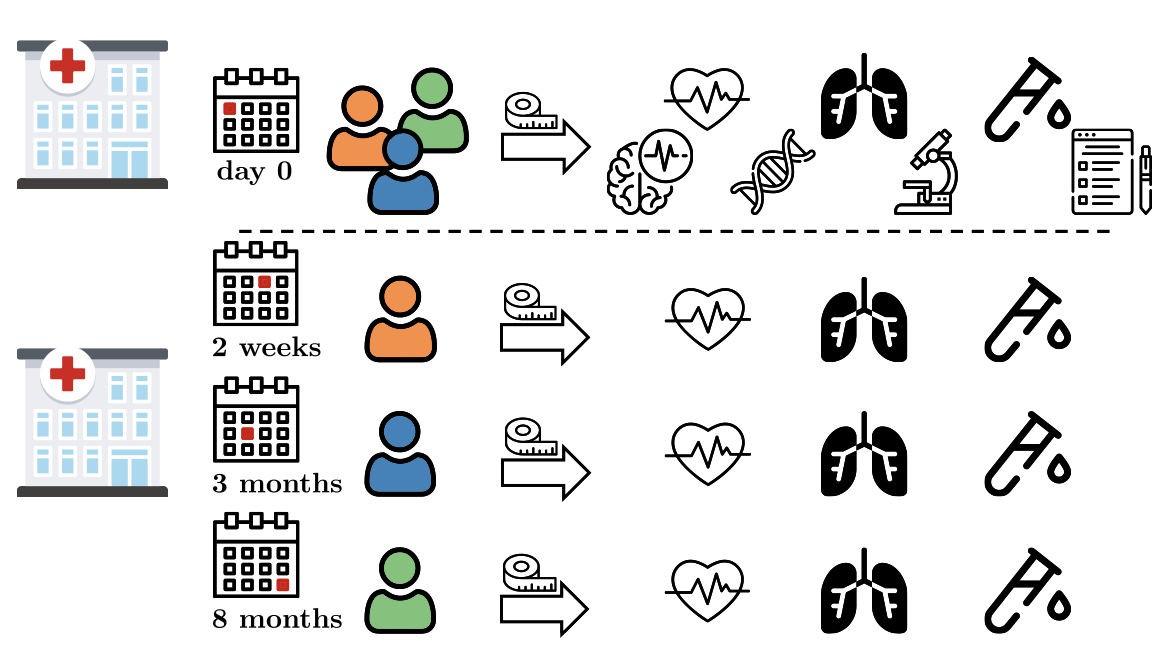

Especially in the beginning, when setting up new cohorts or registries, a typical situation might be that only baseline measurements and a single further measurement time point are available for each individual and we are facing the question of what can be learned from the data in such an early phase of the study, when only a baseline characterization and one follow-up measurement are available. 

Such a scenario is illustrated exemplarily in the figure above, where we encounter the following scenario: A group of study participants comes to the study center at a baseline timepoint, say $t_0$, where a lot of measurements is taken from them. Then, each individual comes back at a second time point to obtain measurements of only a subset of the larger number of baseline variables. However, this second measurement time point varies for different individuals, i.e., the time spans between first (baseline) and second (follow-up) measurement vary between individuals and range from a few days or weeks up to several month. 

So, instead of having repeated measurements of the same quantity, we are rather observing individual temporal development patterns measured at only two timepoints.

Our aim was to develop a model that can from data like that extract individual temporal development patterns despite the irregularity and sparsity of the time grid. 

So, to further investigate, let's first simulate some data and look at it:

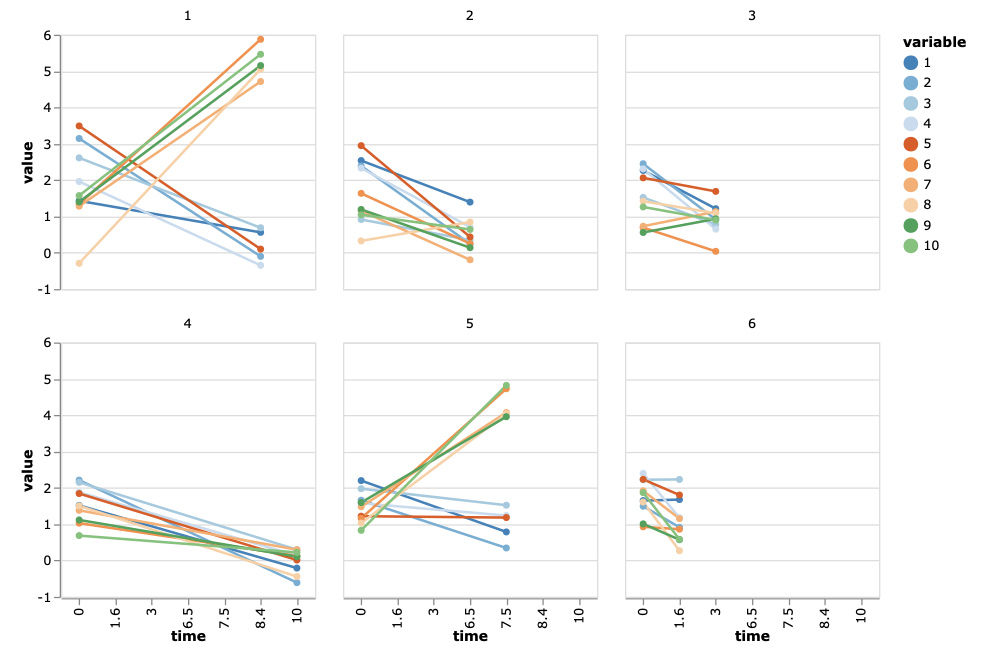

**Three central features:**
   - different second measurement time points
   - distinct development patterns
   - groups of variables that share common trends --> lower-dimensional underlying structure

To model this, we came up with the following:

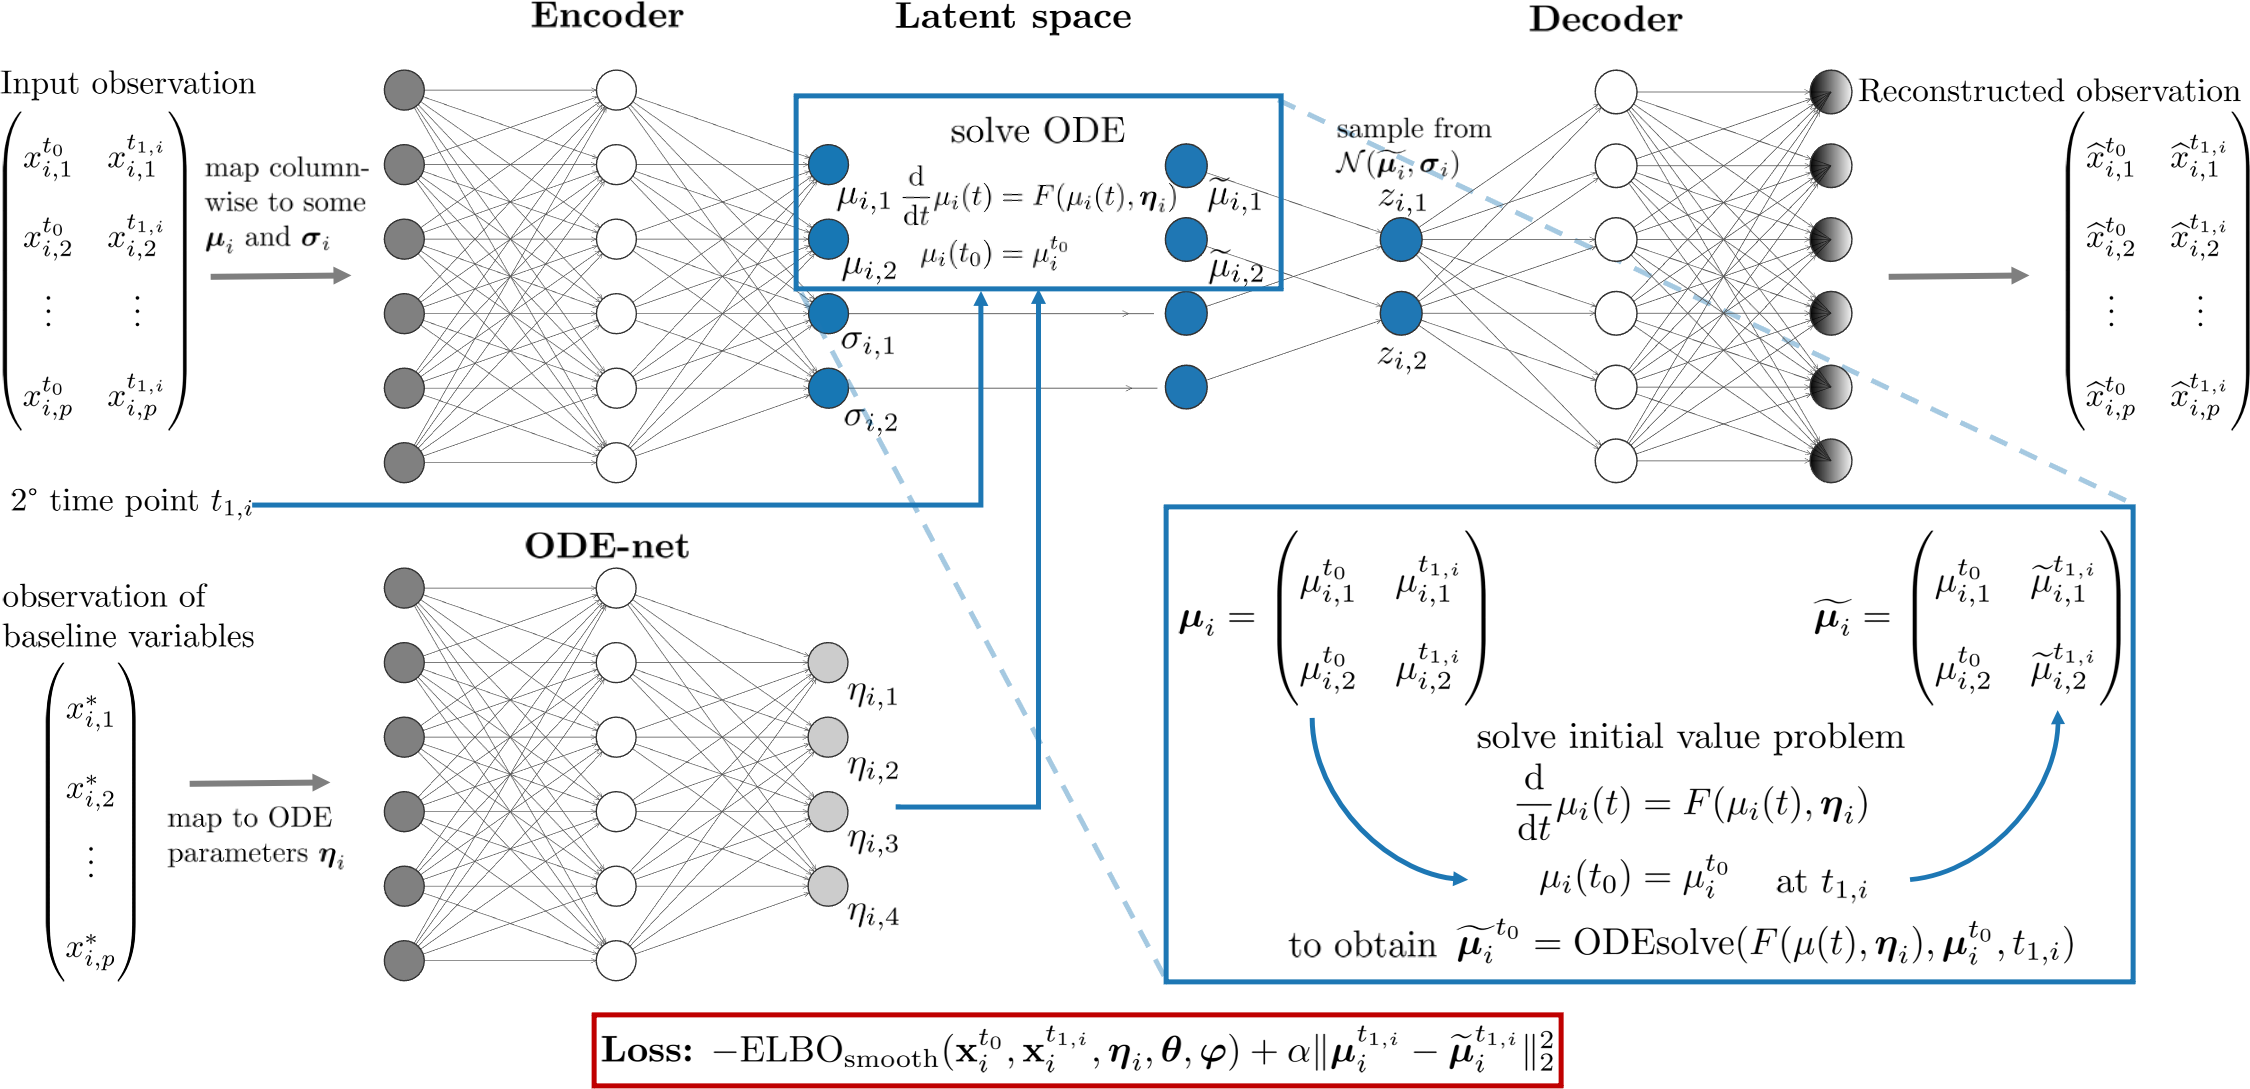

(For the details, have a look at our [preprint](https://arxiv.org/abs/2012.00634))

For now, let's see whether the model actually works! 

## Simulation design 

For that, we have designed a simulation design: We define the true latent developments as solutions of ODE systems and simulate data basically by sampling from the true ODE solution trajectories, i.e. adding some random noise to the true trajectories. Then, we try to recover the ground-truth developments with our model. 

### Setup 

First, we set up the Julia environment and the necessary packages. 

In [1]:
using Pkg;
Pkg.activate("../.")
Pkg.instantiate()
Pkg.status()

  Activating environment at `~/Desktop/DeepDynamicModelingWithJust2TimePoints/Project.toml`


      Status `~/Desktop/DeepDynamicModelingWithJust2TimePoints/Project.toml`
  [6e4b80f9] BenchmarkTools v1.2.1
  [336ed68f] CSV v0.9.10
  [a93c6f00] DataFrames v1.2.2
  [aae7a2af] DiffEqFlux v1.44.0
  [31c24e10] Distributions v0.25.24
  [587475ba] Flux v0.12.8
  [033835bb] JLD2 v0.4.15
  [b964fa9f] LaTeXStrings v1.3.0
  [1dea7af3] OrdinaryDiffEq v5.65.5
  [91a5bcdd] Plots v1.23.5
  [112f6efa] VegaLite v2.6.0
  [9a3f8284] Random


In [2]:
using Distributions
using Random
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using Plots 
using LaTeXStrings
gr()

Plots.GRBackend()

### Simulate the data 

The ground-truth developments that we try to recover with our model are defined as solutions of linear 2-dimensional ODE systems. 

We first define the system and two the corresponding ODE problems with distinct parameters, corresponding to two distinct development patterns.

In [3]:
# define true underlying ODE system
function linear_2d_system(du,u,p,t)
    a11, a12, a21, a22 = p
    z1,z2 = u
    du[1] = dz1 = a11 * z1 + a12 * z2
    du[2] = dz2 = a21 * z1 + a22 * z2
end
  
# define initial condition
true_u0 = Float32[2, 1]
# define time span on which to solve the ODE
tspan = (0.0f0, 10.0f0)
# define parameters for the two distinct groups
true_odeparams_group1 = Float32[-0.2, 0.00, 0.00, -0.2]
true_odeparams_group2 = Float32[-0.2, 0.00, 0.00, 0.2]
  
# define corresponding ODE problems for the two groups
prob1 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group1)
prob2 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group2)

ODEProblem with uType Vector{Float32} and tType Float32. In-place: true
timespan: (0.0f0, 10.0f0)
u0: 2-element Vector{Float32}:
 2.0
 1.0

Now, we can solve the ODE systems and look at the solutions for poth patterns. 

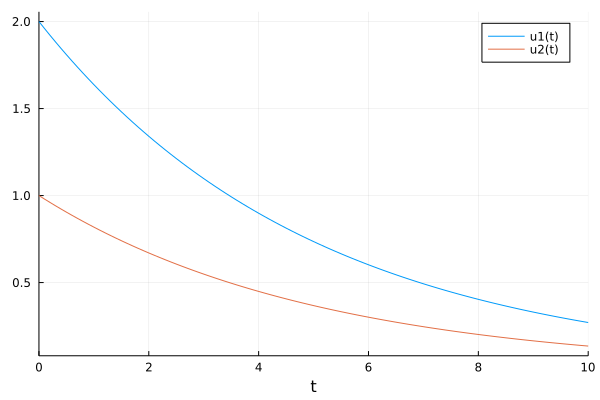

In [4]:
# solve ODE systems to obtain "true" underlying trajectory in each group
dt=0.1
sol_group1 = solve(prob1, Tsit5(), saveat = dt);
sol_group2 = solve(prob2, Tsit5(), saveat = dt);
plot(sol_group1)

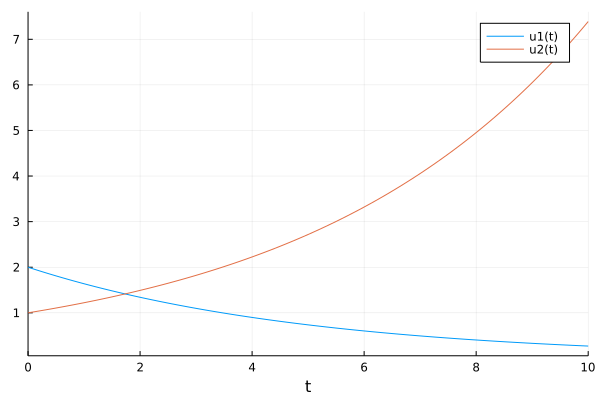

In [5]:
plot(sol_group2)

Now, we simulate data of `n` individuals by adding noise to the true development patterns:

First, we randomly assign each individual into one of two groups, corresponding to the two distinct development patterns `sol_group1` and `sol_group2` created above. 

Next, for each simulated individual, we randomly draw a second measurement time point (or several subsequent random measurement time points) between `t_start`(default: 1.5) and `t_end` (default: 10) (here, `t_start`, `t_end`  $\in$ `tspan` is necessary). 

Then, for each individual, we simulate `p` measurements of each dimension of the ODE solution, i.e., for a 2-dimensional ODE system as in this example, we have $2*$ `p` variables. We do this by adding a variable-specific and an individual-specific measurement error to the true ODE solution of the individual's group at the individual-specific second measurement time point. These errors are drawn from to $\mathcal{N}(0,\sigma_{\mathrm{var}})$ and $\mathcal{N}(0,\sigma_{\mathrm{ind}})$, respectively.

First, we import some user-defined functions for simulating the data:

In [6]:
include("../src/simulation.jl")

generate_baseline_4params (generic function with 1 method)

In [23]:
# define numbers of individuals and variables 
n = 100 
p = 10
q, q_info = 50, 10

# choose simulation setting for baseline variables 
baseline_simulation = "trueparams" # alternative: "groupsonly"

# set seed for reproducibility
Random.seed!(12);

# generate time dependent variables
xs, tvals, group1, group2 = generate_xs(n, p, true_u0, sol_group1, sol_group2); 
# default vals: t_start=1.5, t_end=10, maxntps=10, dt=0.1, σ_var=0.1, σ_ind=0.5

Finally, we generate the corresponding baseline variables that reflect are more extensive characterization of the individuals at the baseline time point $t_0$. Here, we distinguish between two possibilites of either drawing from the true ODE parameters with some added random noise, or drawing from the group membership information encoded as $\pm 1$ with random noise. In both scenarios, we simulate `q_info` variable with that noisy information about either the ODE parameters or the group membership, and simulate additional variables that contain purely random noise, until we end up with a total of `q` baseline variables.  

In [24]:
# generate baseline variables
if baseline_simulation == "trueparams"
    x_baseline = generate_baseline(n, q, q_info, group1, true_odeparams_group1, true_odeparams_group2); 
    # defaul vals: σ_info=0.1, σ_noise=0.1
elseif baseline_simulation == "groupsonly"
    x_baseline = generate_baseline(n, q, q_info, group1); 
    # default vals: σ_info=1, σ_noise=1
else
    error("Please select either 'trueparams' or 'groupsonly' as mode for simulation of baseline variables")
end

100-element Vector{Vector{Float64}}:
 [-0.13484747523773022, -0.21396368101922525, -0.34610774899846464, -0.3213698736387119, -0.23449025072359134, -0.22815755772206933, -0.15224920657217636, -0.28274611737225097, -0.15769583847388174, -0.1690204521385787  …  0.0488063144128664, 0.012772199900954767, -0.02409585923388871, 0.10400414164823331, -0.03272416606764967, -0.12160831984633358, 0.06982971996876308, -0.0032741474136807713, -0.005805277996947248, -0.05038819129501996]
 [-0.1595038025739475, -0.25278854294383285, -0.10579220315306186, -0.08911291652898418, -0.15193112777359907, 0.06031240672887167, 0.392192065530683, 0.14780521133781307, 0.19149370254565046, 0.24884837028240053  …  0.04711835365366793, -0.07896177590304179, 0.06465917166628879, -0.04569422340429962, 0.07868094607034642, 0.06075122691044879, -0.07620964077909186, 0.0012340511319527466, 0.09234891403581696, 0.020145015877047662]
 [-0.27942608358970467, -0.3010993996004742, -0.15582208536675915, -0.09264245931010544,

Let's have a look at the data we generated (showing only the true ODE solutions as lines and the first row and the solutions and drawn measurements as dots in the second row), separately for each group (=column).

Again, we first import some functions for convenient plotting, to visualize the data and the learned trajectories:

In [25]:
include("../src/plotting.jl")

plot_batch_solution (generic function with 1 method)

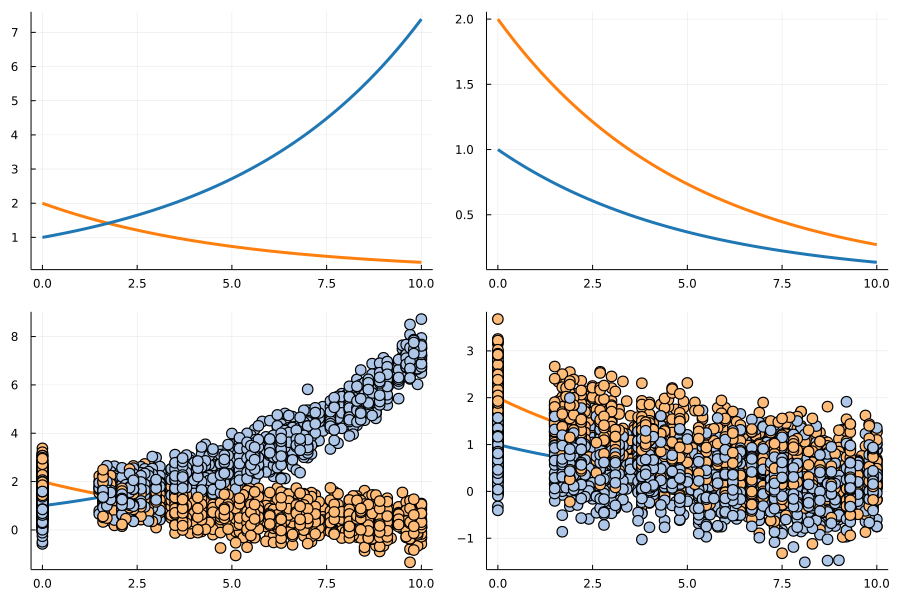

In [26]:
# look at data: 
data = simdata(xs, x_baseline, tvals, group1, group2);

plot(plot_truesolution(2, data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(2, data, sol_group1, sol_group2, showdata=true), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=true),
    layout = (2,2),
    legend = false,
    size = (900,600)
)

## Define and train model 

Now, let's define our model and how to initialize it by specifying the neural network architectures of the encoder, decoder and the ODE-net mapping the baseline variables to the individual-specific ODE parameters.

In [27]:
mutable struct odevae
    p 
    q
    zdim 
    paramNN
    encoder
    encodedμ 
    encodedlogσ 
    decoder
    decodedμ 
    decodedlogσ 
    ODEprob
end

In [28]:
# initialize model
function init_vae(p, q, zdim, nODEparams, ODEprob; seed::Int=1234)
    myinit = Flux.glorot_uniform
    shift(arg) = sigmoid(arg).-0.5
    # seed
    Random.seed!(seed)
    # parameter network
    paramNN = Chain(Dense(q,q,tanh, init=myinit), 
                Dense(q, nODEparams, arg ->(shift(arg)), init=myinit), 
                Flux.Diagonal(nODEparams))
    #   VAE encoder
    Dz, Dh = zdim, p
    encoder, encodedμ, encodedlogσ = Dense(p, Dh, arg ->(tanh.(arg) .+ 1)), Dense(Dh, Dz), Chain(Dense(Dh, Dz, arg -> -relu(arg)), Flux.Diagonal(Dz))
    # VAE decoder
    decoder, decodedμ, decodedlogσ = Dense(Dz, Dh, tanh), Dense(Dh, p), Dense(Dh, p)
    return odevae(p, q, zdim, paramNN, encoder, encodedμ, encodedlogσ, decoder, decodedμ, decodedlogσ, ODEprob)
end


init_vae (generic function with 1 method)

Next, we define the model loss: We augment the classical VAE loss given by the negative evidence lower bound (ELBO) by adding a term that enforces consistency of latent representation before solving the ODE (=obtained directly from putting the data from subsequent measurement time points through the VAE encoder) and after solving the ODE with the individual-specific parameters obtained from the ODE-net and the baseline variables. 

In [29]:
latentz(μ, logσ) = μ .+ sqrt.(exp.(logσ)) .* randn(Float32,size(μ)...) # sample latent z,

kl_q_p(μ, logσ) = 0.5 .* sum(exp.(logσ) + μ.^2 .- 1 .- (logσ),dims=1)

logp_x_z(m::odevae, x, z) = sum(logpdf.(Normal.(m.decodedμ(m.decoder(z)), sqrt.(exp.(m.decodedlogσ(m.decoder(z))))), x),dims=1) # get reconstruction error

sqnorm(x) = sum(abs2, x)
reg(m::odevae) = sum(sqnorm, Flux.params(m.decoder,m.decodedμ,m.decodedlogσ)) # regularisation term in loss

getparams(m::odevae) = Flux.params(m.encoder, m.encodedμ, m.encodedlogσ, m.decoder, m.decodedμ, m.decodedlogσ, m.paramNN) # get parameters of VAE model

function loss(X, Y, t, m::odevae)
    latentμ, latentlogσ = m.encodedμ(m.encoder(X)), m.encodedlogσ(m.encoder(X))
    learnedparams = m.paramNN(Y)
    curparams = [learnedparams[1], m.ODEprob.p[2], m.ODEprob.p[3], learnedparams[2]]
    curts = Int.(floor.(t .*(1 ./dt) .+1))
    smoothμ = Array(solve(m.ODEprob, Tsit5(), u0 = [latentμ[1,1], latentμ[2,1]], p=curparams, saveat=dt))[:,curts]
    combinedμ = hcat(latentμ[:,1],smoothμ)
    combinedz = latentz.(combinedμ, latentlogσ)
    ELBO = 1.0 .* logp_x_z(m, X, combinedz) .- 0.5 .* kl_q_p(combinedμ, latentlogσ)
    lossval = sum(-ELBO) + 0.01*reg(m) + 1.0*sum((smoothμ .- latentμ[:,2:end]).^2)
    return lossval
end

function loss_wrapper(m::odevae) 
    return function (X, Y, t) loss(X, Y, t, m) end 
end

loss_wrapper (generic function with 1 method)

## Train model!

Now it's time to train the model: We initialize it and define some callback functions to monitor and visualize the training process, before starting the training loop.

### Instantiate 

First, we define the architecture of our model and initialize the model (with random weights). 

In [30]:
zdim = nODEparams = 2
m = init_vae(p, q, zdim, nODEparams, prob1);

We specify the model loss, the optimizer and the learning rate for the stochastic gradient descent:

In [31]:
L = loss_wrapper(m)
ps = getparams(m)
opt = ADAM(0.0005)

ADAM(0.0005, (0.9, 0.999), IdDict{Any, Any}())

Finally, we define the training data for the model and define two callback functions: One to show the mean of the loss function across the dataset after each training epoch (to verify that it decreases), and one to plot the currently learned data encoding and trajectories from four exemplary individuals. 

In [16]:
trainingdata = zip(xs, x_baseline, tvals);
evalcb() = @show(mean(L.(xs, x_baseline, tvals)))
evalcb_zs() = eval_z_trajectories(xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, swapcolorcoding=true)

evalcb_zs (generic function with 1 method)

### Now, it's time to start training!

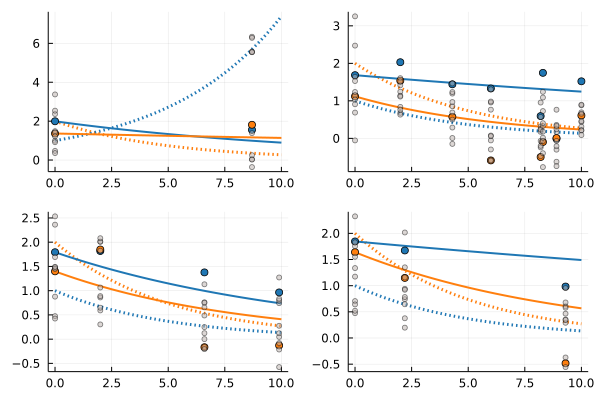

mean(L.(xs, x_baseline, tvals)) = 187.08172326306453
mean(L.(xs, x_baseline, tvals)) = 

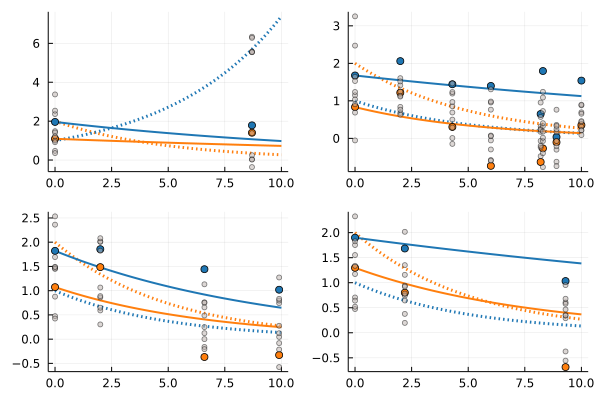

164.24578108340145


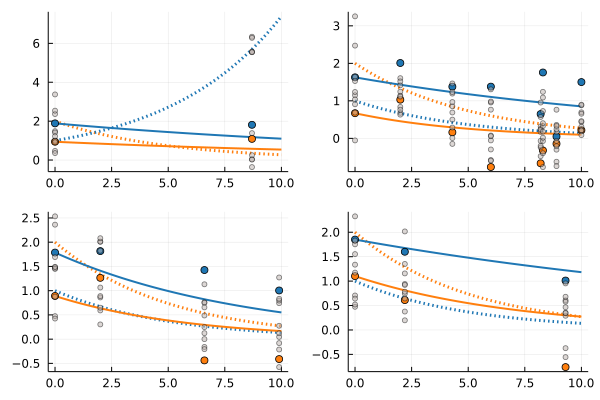

mean(L.(xs, x_baseline, tvals)) = 150.18806772066137
mean(L.(xs, x_baseline, tvals)) = 

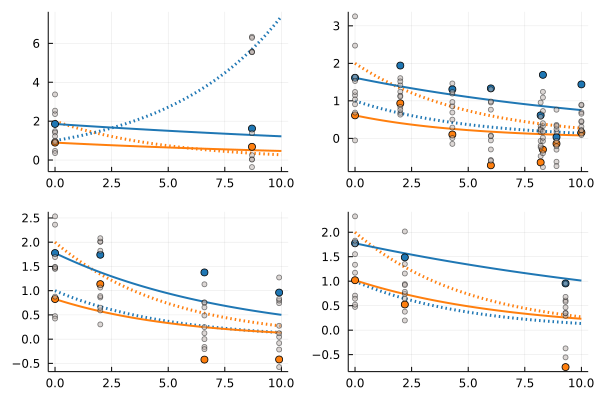

140.7849738819017


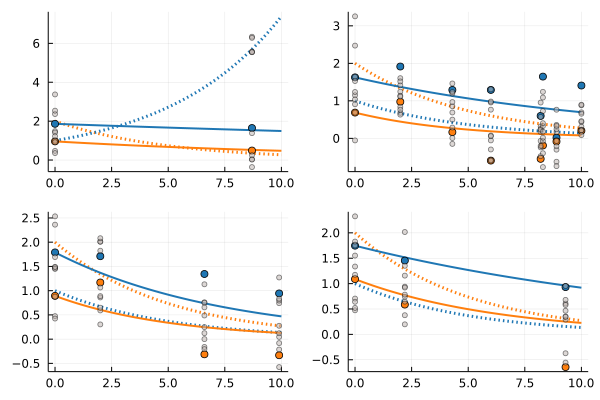

mean(L.(xs, x_baseline, tvals)) = 134.55955532492234
mean(L.(xs, x_baseline, tvals)) = 

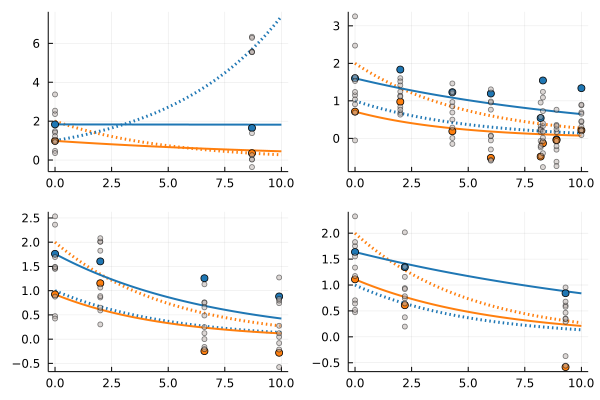

129.4565451392721


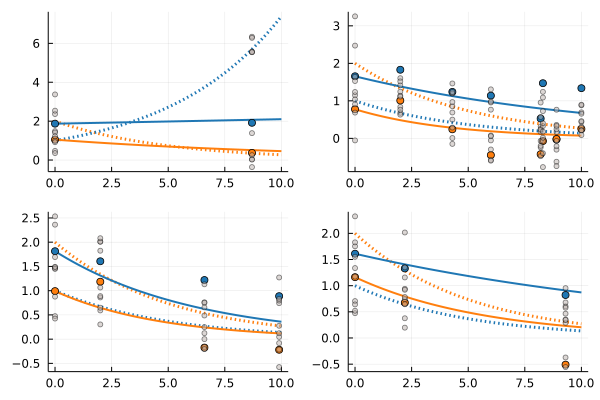

mean(L.(xs, x_baseline, tvals)) = 126.91451025300371
mean(L.(xs, x_baseline, tvals)) = 

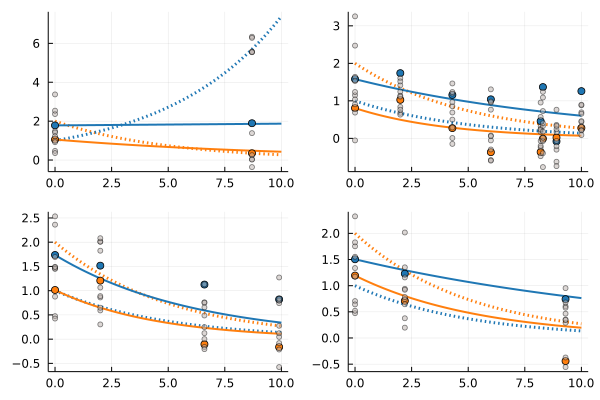

122.58939833930467


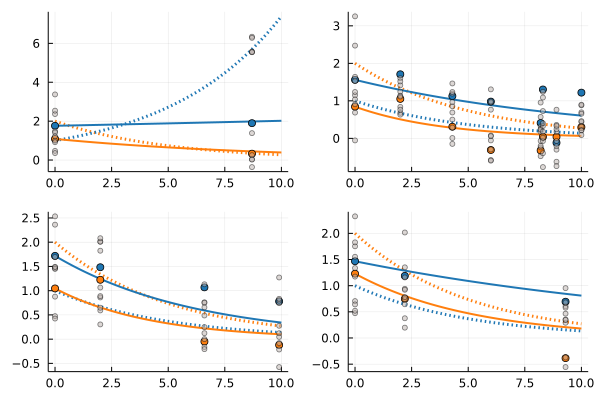

mean(L.(xs, x_baseline, tvals)) = 120.38497240237713
mean(L.(xs, x_baseline, tvals)) = 

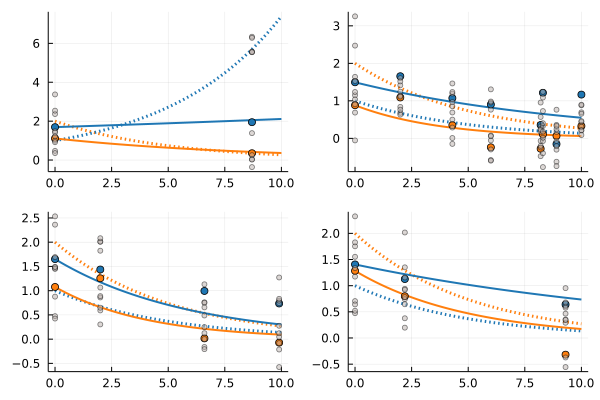

117.70092710984102


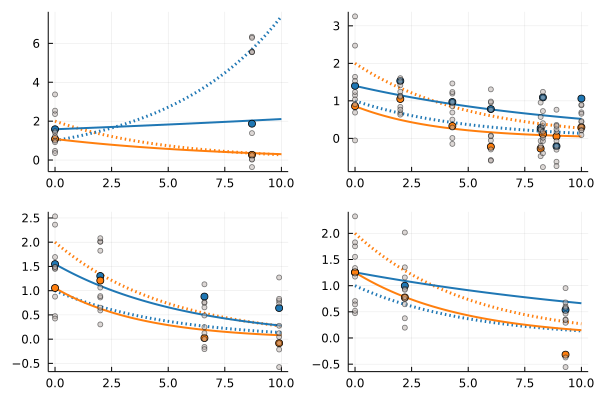

mean(L.(xs, x_baseline, tvals)) = 119.35039585974917
mean(L.(xs, x_baseline, tvals)) = 

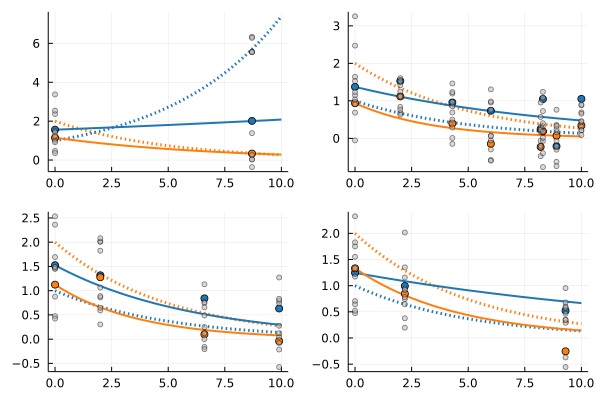

113.68169110523368


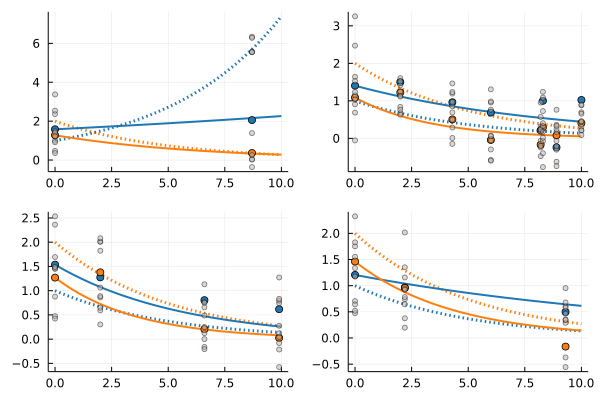

mean(L.(xs, x_baseline, tvals)) = 111.85786555817283
mean(L.(xs, x_baseline, tvals)) = 

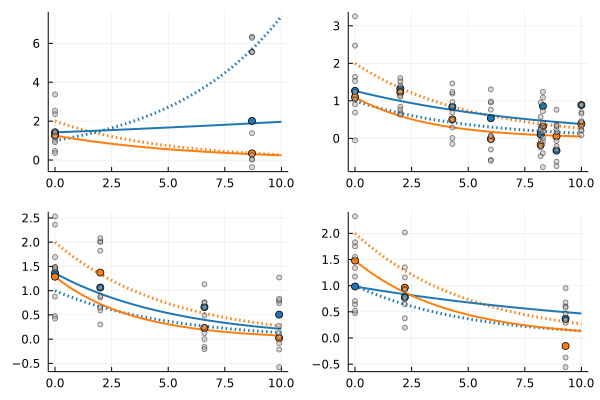

111.18314195666288


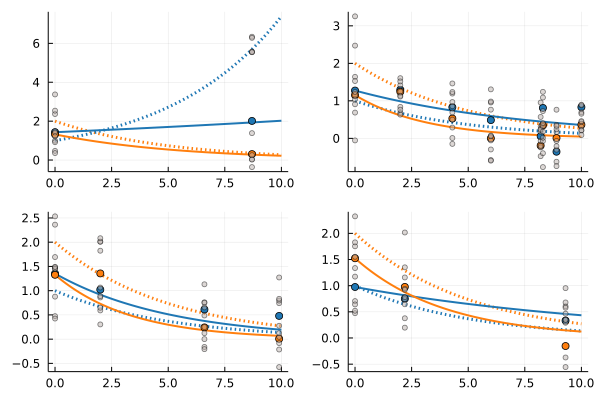

mean(L.(xs, x_baseline, tvals)) = 110.81492617804642
mean(L.(xs, x_baseline, tvals)) = 

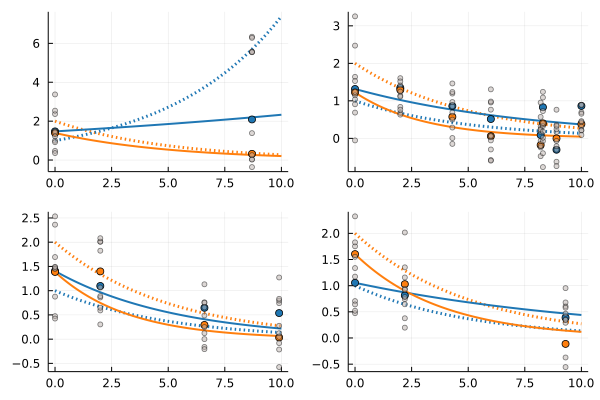

107.81686141245824


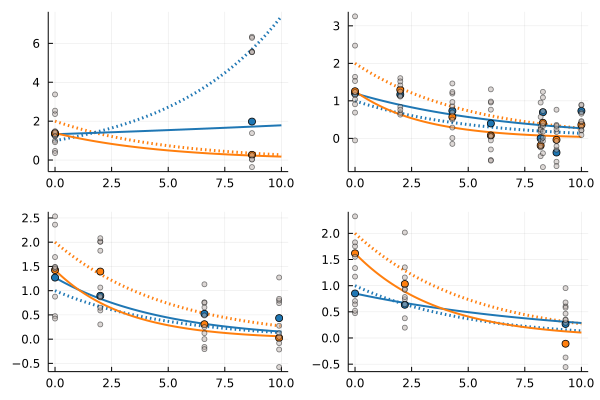

mean(L.(xs, x_baseline, tvals)) = 108.86972582743903
mean(L.(xs, x_baseline, tvals)) = 

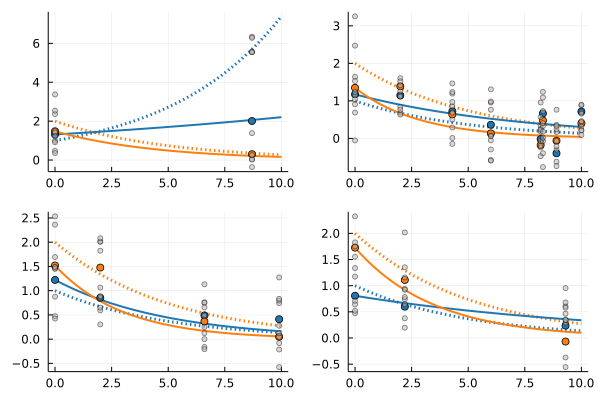

105.29283401860843


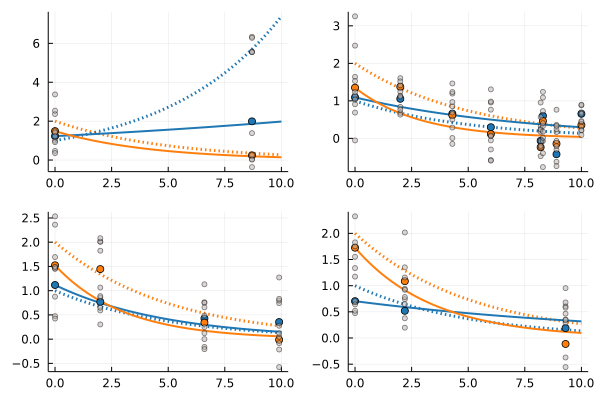

mean(L.(xs, x_baseline, tvals)) = 106.46725380214873
mean(L.(xs, x_baseline, tvals)) = 

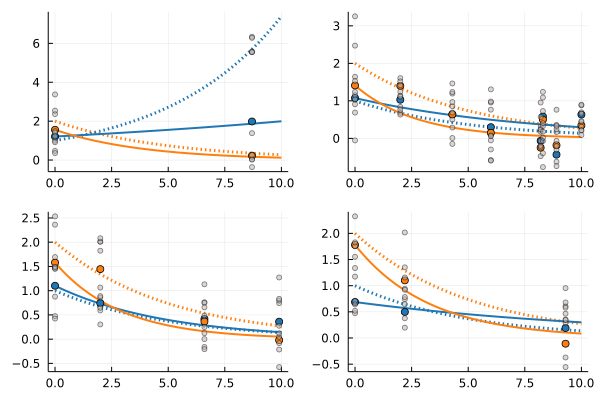

102.35066213186546


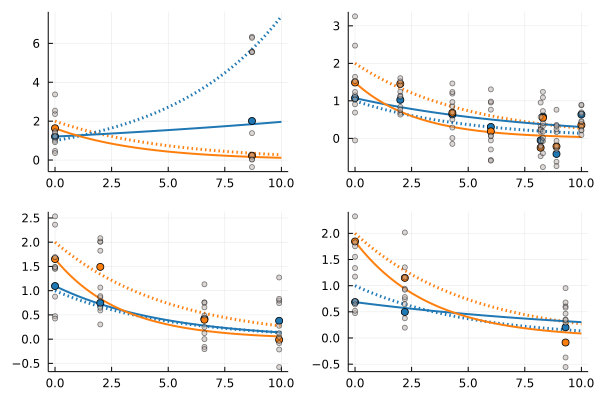

mean(L.(xs, x_baseline, tvals)) = 102.44503174219513
mean(L.(xs, x_baseline, tvals)) = 

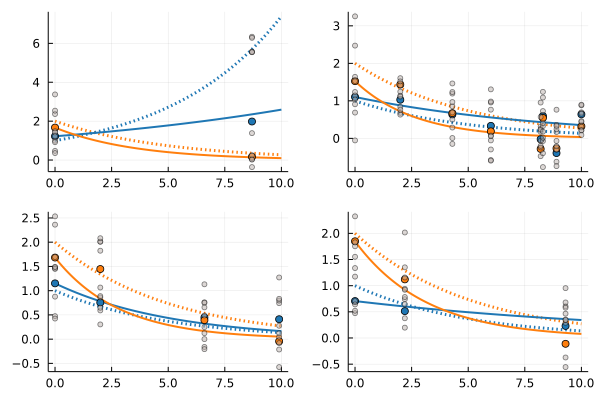

102.08457152406847


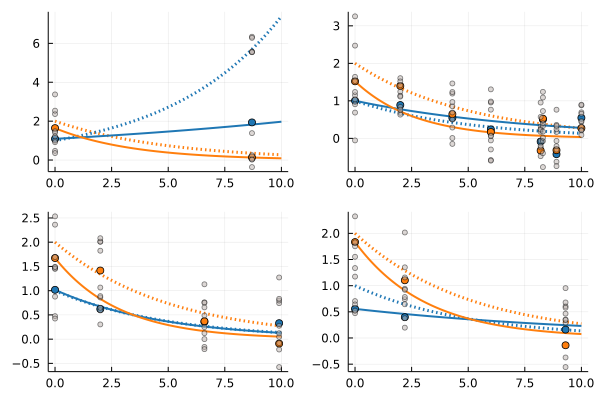

mean(L.(xs, x_baseline, tvals)) = 100.29799428069323
mean(L.(xs, x_baseline, tvals)) = 

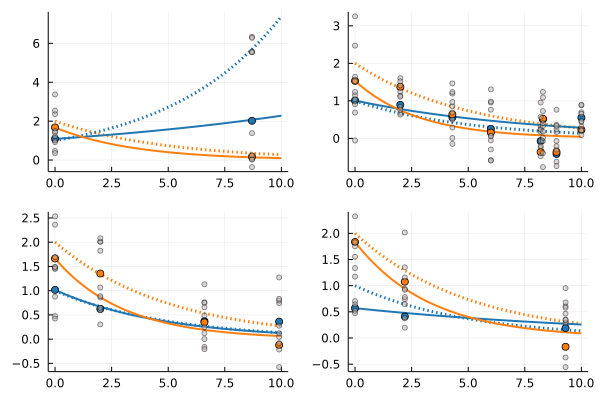

98.50503717282157


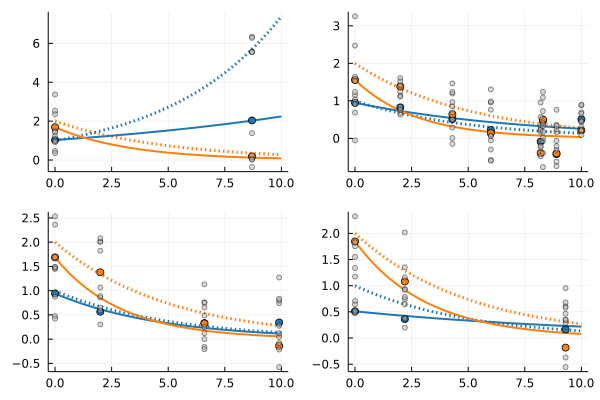

mean(L.(xs, x_baseline, tvals)) = 98.72232256129226
mean(L.(xs, x_baseline, tvals)) = 

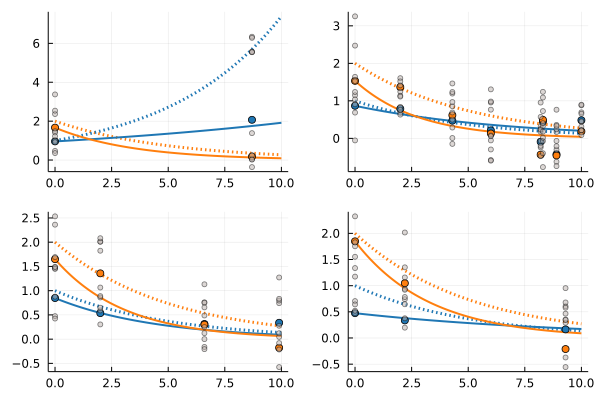

98.23351317896166


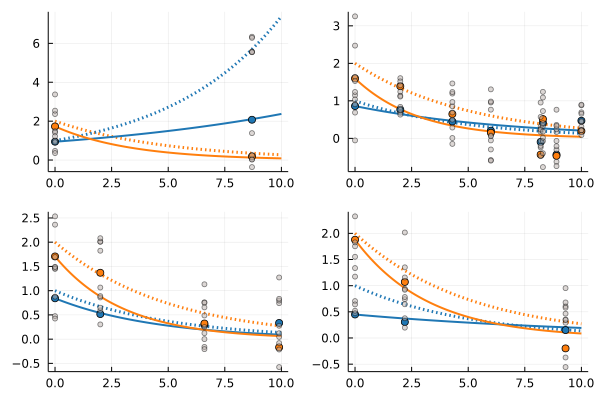

mean(L.(xs, x_baseline, tvals)) = 96.93146174010431
mean(L.(xs, x_baseline, tvals)) = 

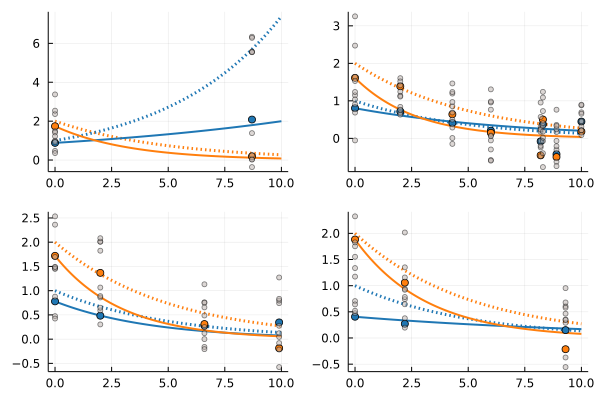

96.97616625756824


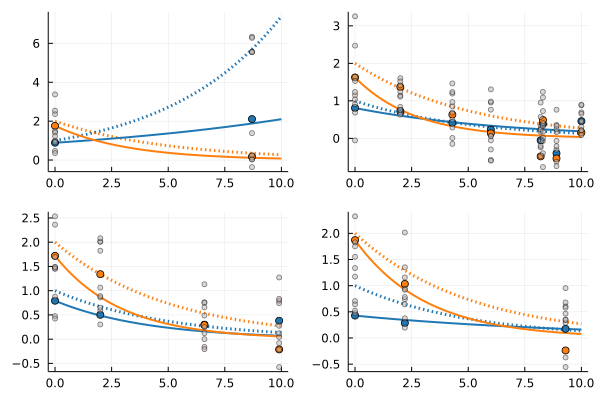

mean(L.(xs, x_baseline, tvals)) = 95.90306742767592
mean(L.(xs, x_baseline, tvals)) = 

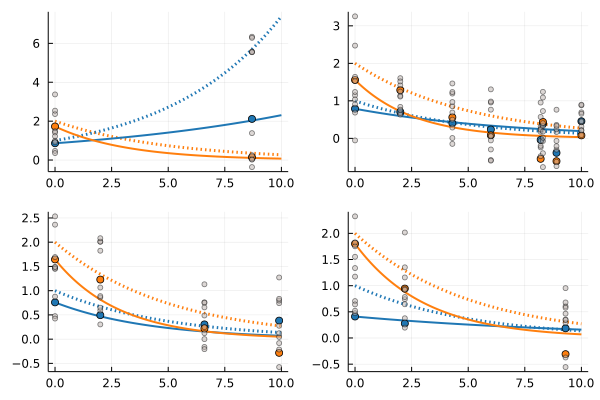

94.00164194967272


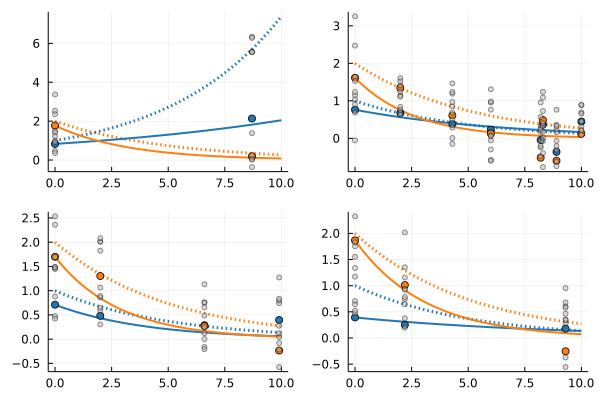

mean(L.(xs, x_baseline, tvals)) = 93.62667278573984
mean(L.(xs, x_baseline, tvals)) = 

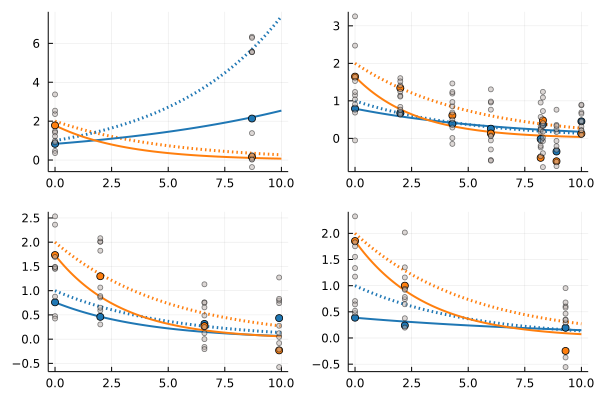

94.48184814045202


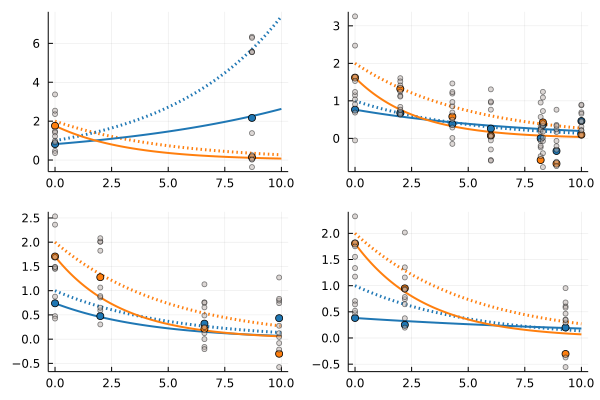

mean(L.(xs, x_baseline, tvals)) = 95.37722907769452
mean(L.(xs, x_baseline, tvals)) = 

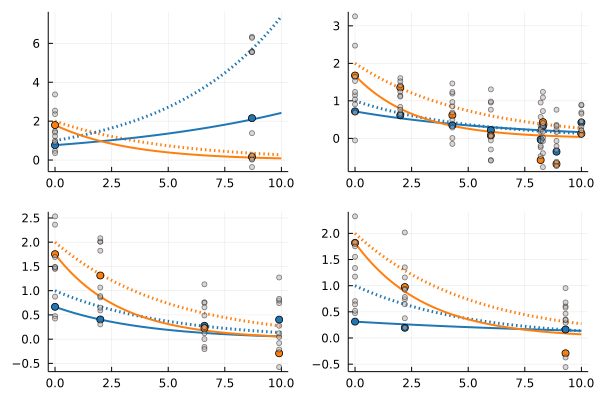

96.13903658156455


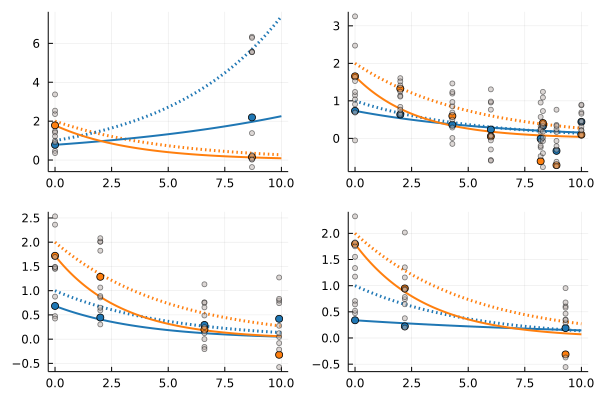

mean(L.(xs, x_baseline, tvals)) = 93.74719277379398
mean(L.(xs, x_baseline, tvals)) = 

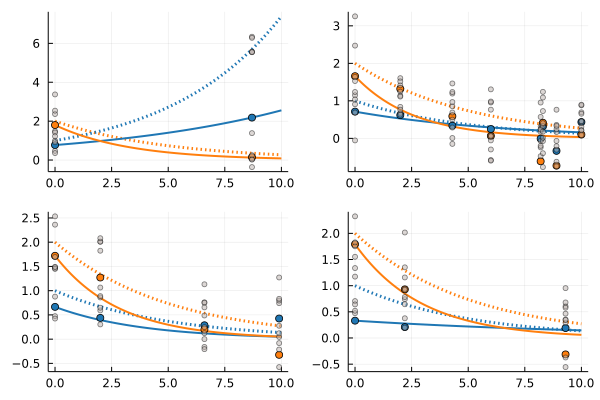

94.49838099331365


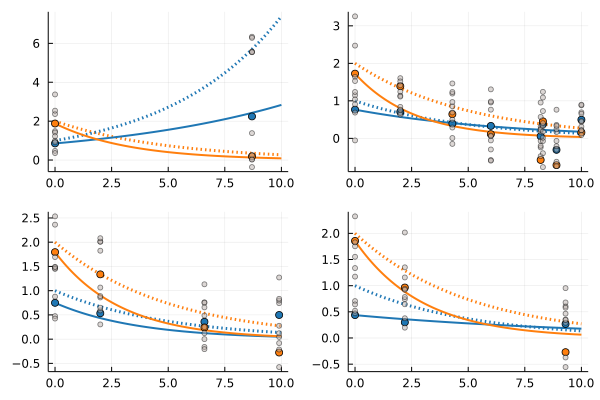

mean(L.(xs, x_baseline, tvals)) = 93.4995767255001
mean(L.(xs, x_baseline, tvals)) = 

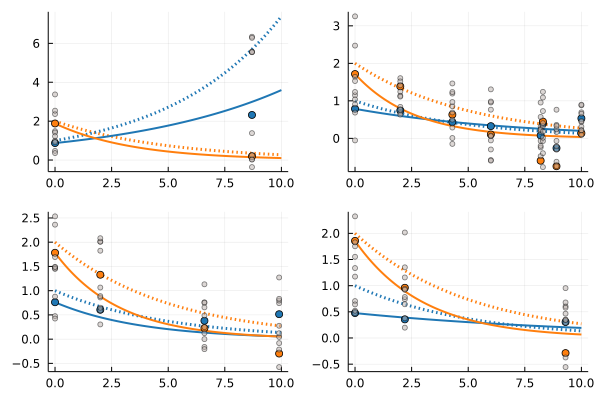

92.53607621463429


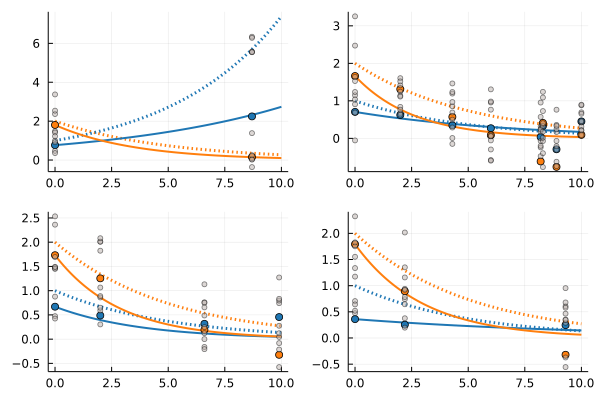

mean(L.(xs, x_baseline, tvals)) = 92.62569966779996
mean(L.(xs, x_baseline, tvals)) = 

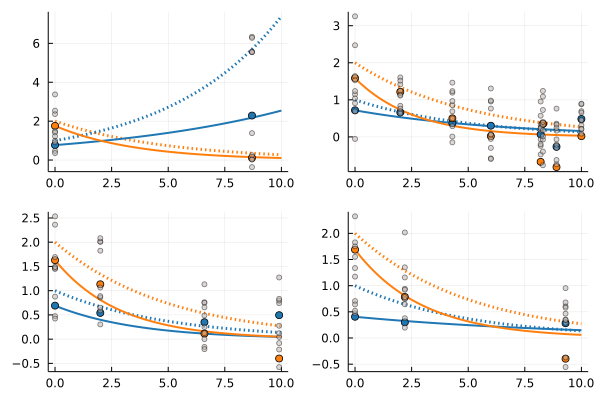

93.52821690717465


In [32]:
for epoch in 1:40
    Flux.train!(L, ps, trainingdata, opt)
    evalcb()
    evalcb_zs()
end

## Look at the results 

We can now visualize what the model has learnt, by looking at the fitted trajectories in each of the two groups from each individual (thin solid lines in the plot) and compare them to the ground-truth solutions (dashed thicker lines). Additionally, we can visually evaluate how well the latent representations before and after solving the ODE match by comparing the dots (=latent representation means obtained directly from the encoder) with the solid lines (latent fitted ODE solutions). 

First, we look at some exemplary individual solutions, one from each group: 

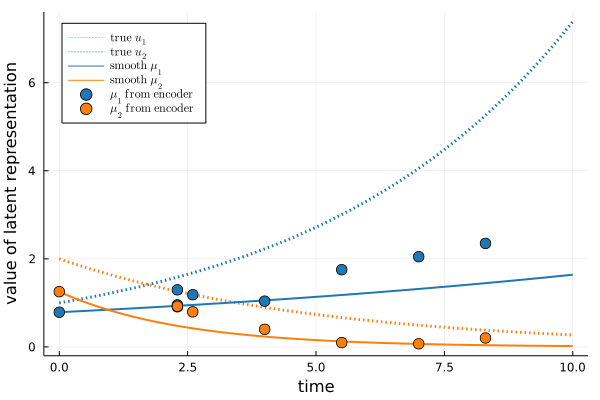

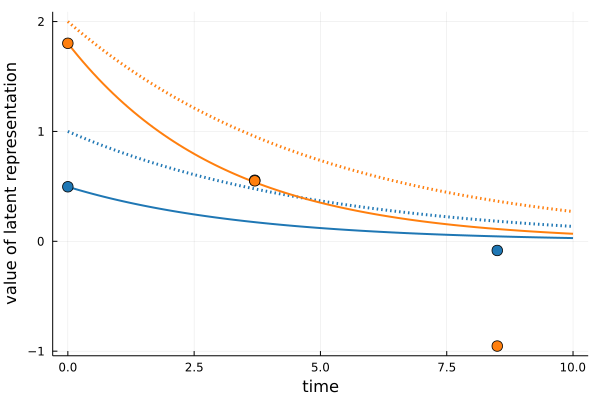

In [33]:
p1 = plot_individual_solutions(20,xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, 
                                swapcolorcoding=true, showlegend=true)
p2 = plot_individual_solutions(28,xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, 
                                swapcolorcoding=true, showlegend=false)
display(p1)
display(p2)

Next, we look at the solutions across the datasets and plot the solutions from all individuals in one group together: 

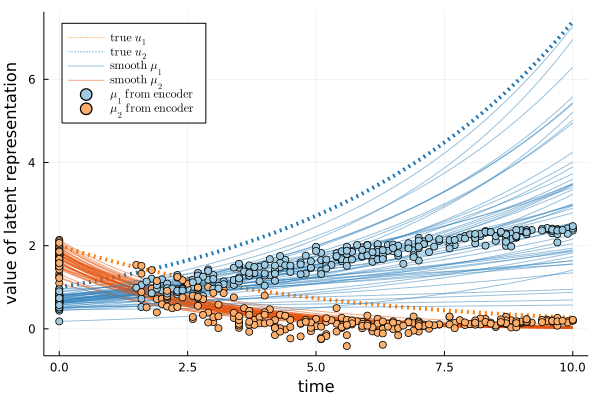

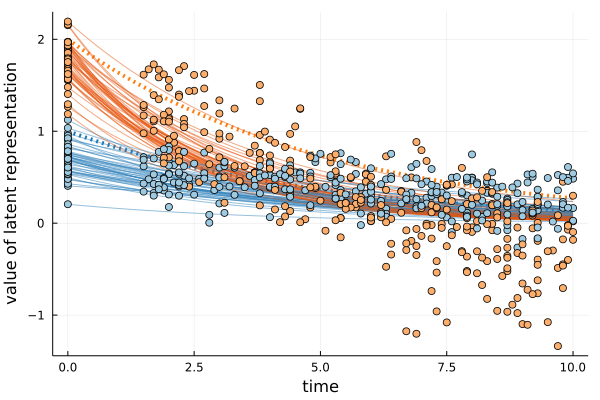

In [34]:
# solutions across the entire dataset
data = simdata(xs, x_baseline, tvals, group1, group2);

p3 = allindsplot(2, data, m, sol_group1, sol_group2, swapcolorcoding=true)
p4 = allindsplot(1, data, m, sol_group1, sol_group2, swapcolorcoding=true, showlegend=false)

display(p3)
display(p4)